In [18]:
import os
import re
from collections import Counter

import anndata
import numpy as np
import pandas as pd
import scgen
import scanpy as sc
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import logging

In [3]:
DATA_DIR = '/home/estorrs/data/single_cell_classification'
MODEL_DIR = '/home/estorrs/pollock/models'

In [4]:
run_name = 'pbmc_bench_10x-v3'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', '10Xv3', '10Xv3_pbmc1.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', '10Xv3', '10Xv3_pbmc1Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [100]:
run_name = 'zheng_68k_unsorted'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Zheng 68K', 'Filtered_68K_PBMC_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Zheng 68K', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 10000
epochs = 5
batch_size = 64

In [101]:
%%time
expression_df = pd.read_csv(
    expression_fp,
    sep=sep)
expression_df

CPU times: user 6min 18s, sys: 18 s, total: 6min 36s
Wall time: 6min 34s


,Unnamed: 0,AL627309.1,AP006222.2,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,FAM87B,LINC00115,FAM41C,RP11-54O7.1,...,AC145212.1,MGC39584,AC011043.1,ZNF84.1,AL592183.1,AC011841.1,AL354822.1,KIR2DL2,PNRC2.1,SRSF10.1
0,AAACATACACCCAA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,AAACATACCCCTCA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AAACATACCGGAGA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AAACATACTAACCG-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AAACATACTCTTCA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65938,TTTGCATGACACCA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65939,TTTGCATGAGCCTA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65940,TTTGCATGCTAGCA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65941,TTTGCATGCTGCAA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
expression_df = expression_df.set_index(sample_column)
expression_df

,AL627309.1,AP006222.2,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,FAM87B,LINC00115,FAM41C,RP11-54O7.1,SAMD11,...,AC145212.1,MGC39584,AC011043.1,ZNF84.1,AL592183.1,AC011841.1,AL354822.1,KIR2DL2,PNRC2.1,SRSF10.1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
AAACATACACCCAA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
AAACATACCCCTCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATACCGGAGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATACTAACCG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATACTCTTCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCATGACACCA-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGCATGAGCCTA-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGCATGCTAGCA-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
label_df = pd.read_csv(
    label_fp,
    sep=sep
    )
label_df

,x
0,CD8+ Cytotoxic T
1,CD8+/CD45RA+ Naive Cytotoxic
2,CD4+/CD45RO+ Memory
3,CD19+ B
4,CD4+/CD25 T Reg
...,...
65938,CD8+/CD45RA+ Naive Cytotoxic
65939,CD8+ Cytotoxic T
65940,CD8+/CD45RA+ Naive Cytotoxic
65941,CD8+ Cytotoxic T


In [150]:
adata = anndata.AnnData(X=expression_df.values, obs=label_df)
adata.obs.index = expression_df.index
adata.var.index = expression_df.columns
adata

Transforming to str index.


AnnData object with n_obs × n_vars = 65943 × 20387 
    obs: 'x'

In [151]:
counts = Counter(adata.obs[cell_type_key])
counts.most_common()

[('CD8+ Cytotoxic T', 20307),
 ('CD8+/CD45RA+ Naive Cytotoxic', 16361),
 ('CD56+ NK', 8522),
 ('CD4+/CD25 T Reg', 6116),
 ('CD19+ B', 5579),
 ('CD4+/CD45RO+ Memory', 3031),
 ('Dendritic', 1946),
 ('CD14+ Monocyte', 1944),
 ('CD4+/CD45RA+/CD25- Naive T', 1857),
 ('CD34+', 188),
 ('CD4+ T Helper2', 92)]

In [152]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [153]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

... storing 'x' as categorical


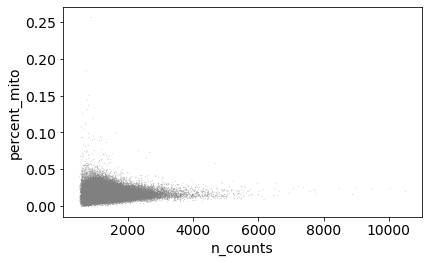

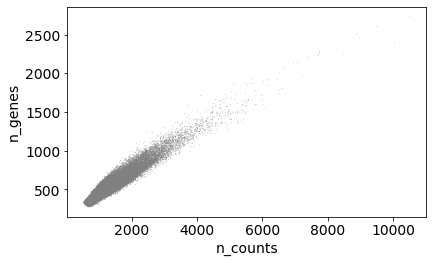

In [154]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [ ]:
adata = adata[adata.obs.n_genes < 6000, :]
adata = adata[adata.obs.percent_mito < 0.05, :]

In [155]:
sc.pp.normalize_total(adata, target_sum=1e4)


In [156]:
sc.pp.log1p(adata)


In [157]:
adata.raw = adata

In [158]:
adata

AnnData object with n_obs × n_vars = 65943 × 17732 
    obs: 'x', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'
    uns: 'log1p'

In [168]:
sc.pp.highly_variable_genes(adata, min_mean=0.005, max_mean=6, min_disp=0.1)


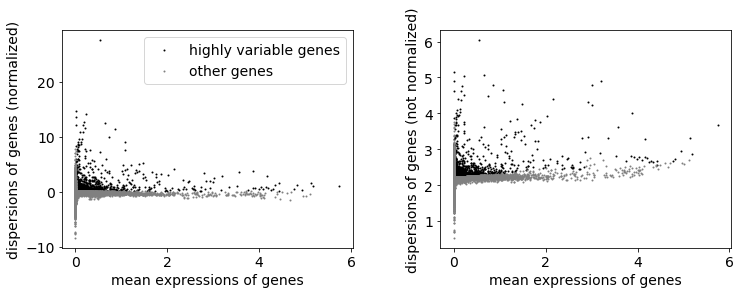

In [169]:
sc.pl.highly_variable_genes(adata)


In [170]:
np.count_nonzero(adata.var.highly_variable)

5436

In [171]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 65943 × 5436 
    obs: 'x', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [175]:
split = .8

idxs = np.arange(adata.shape[0])
np.random.shuffle(idxs)

idxs = idxs[:10000]

train_idxs = idxs[:int(split * idxs.shape[0])]
val_idxs = idxs[int(split * idxs.shape[0]):]

# X = np.copy(adata.X)

# X_train = X[train_idxs]
# X_val = X[val_idxs]

# y_train = adata.obs[cell_type_key][train_idxs]
# y_val = adata.obs[cell_type_key][train_idxs]
train_adata = adata[train_idxs, :].copy()
val_adata = adata[val_idxs, :].copy()

In [176]:
train_adata

AnnData object with n_obs × n_vars = 8000 × 5436 
    obs: 'x', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [177]:
val_adata

AnnData object with n_obs × n_vars = 2000 × 5436 
    obs: 'x', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [197]:
scg = scgen.VAEArith(x_dimension= train_adata.shape[1], model_path="/home/estorrs/pollock/models/vae_clf_test" )

In [ ]:
%%time
history = scg.train(train_data=train_adata, use_validation=True, valid_data=val_adata, n_epochs=2)

In [191]:
train_embeddings = scg.to_latent(train_adata.X)
val_embeddings = scg.to_latent(val_adata.X)

In [192]:
encoder = OrdinalEncoder()
y_train = encoder.fit_transform(np.asarray(train_adata.obs[cell_type_key]).reshape(-1, 1)).flatten()
y_val = encoder.transform(np.asarray(val_adata.obs[cell_type_key]).reshape(-1, 1)).flatten()

In [193]:
clf = RandomForestClassifier()

In [194]:
%%time
clf.fit(train_embeddings, y_train)

CPU times: user 6.87 s, sys: 59.4 ms, total: 6.93 s
Wall time: 6.93 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [195]:
clf.score(train_embeddings, y_train)

1.0

In [196]:
clf.score(val_embeddings, y_val)

0.6175

In [23]:

train = sc.read("./tests/data/train_kang.h5ad",
                backup_url="https://goo.gl/33HtVh")
validation = sc.read("./tests/data/valid_kang.h5ad",
                     backup_url="https://goo.gl/8pdXiQ")

In [24]:
train

AnnData object with n_obs × n_vars = 16893 × 6998 
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [25]:
train.obs

,condition,n_counts,n_genes,mt_frac,cell_type
index,,,,,
AAACATACCAAGCT-1-stimulated,stimulated,1160.0,589,0.0,NK
AAACATACCCCTAC-1-stimulated,stimulated,1729.0,795,0.0,Dendritic
AAACATACCCGTAA-1-stimulated,stimulated,1360.0,585,0.0,CD4T
AAACATACCCTCGT-1-stimulated,stimulated,1442.0,732,0.0,B
AAACATACGAGGTG-1-stimulated,stimulated,1237.0,546,0.0,CD4T
...,...,...,...,...,...
TTTGACTGGCGGAA-1-control,control,2505.0,821,0.0,CD8T
TTTGACTGTCGTAG-1-control,control,3704.0,1101,0.0,CD14+Mono
TTTGACTGTTACCT-1-control,control,2133.0,629,0.0,CD14+Mono


In [26]:
train_new = train[~((train.obs["cell_type"] == "CD4T") &
                    (train.obs["condition"] == "stimulated"))]
validation_new = validation[~((validation.obs["cell_type"] == "CD4T") & (
    validation.obs["condition"] == "stimulated"))]

In [27]:
scg = scgen.VAEArith(x_dimension= train.shape[1], model_path="/home/estorrs/pollock/models/vae_test" )


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [28]:
scg.train(train_data=train_new, use_validation=True, valid_data=validation_new, n_epochs=10)

In [29]:
unperturbed_cd4t = train[((train.obs["cell_type"] == "CD4T") & (train.obs["condition"] == "control"))]


In [30]:
pred, delta = scg.predict(adata=train_new, adata_to_predict=unperturbed_cd4t,
                          conditions={"ctrl": "control", "stim": "stimulated"},
                          cell_type_key="cell_type",
                          condition_key="condition")

In [33]:
pred.shape

(2437, 6998)

In [32]:
delta

array([-8.5041428e-01,  7.5491285e-01,  7.1414309e+00,  1.6379387e+00,
        1.0854130e+00,  8.1711185e-01, -2.4481521e+00,  1.7262746e+00,
       -2.5781548e+00, -2.3019013e+00,  7.2806454e-01, -5.0180864e+00,
        1.1831952e+00,  1.6059554e+00,  6.3880239e+00,  2.4951282e+00,
       -5.2894431e-01,  3.6908561e-01, -1.4838127e+00, -2.7658358e-02,
        8.9996028e-01,  8.5127935e-02,  2.8785080e-02, -4.5098108e-01,
       -1.3649546e-01, -5.9999432e-02,  5.0323641e-01, -2.0177613e-01,
       -1.7653163e-01,  1.5224887e+00,  1.6287723e+00, -4.0245631e-01,
        3.4945824e+00, -5.5778229e-01,  1.0359895e+00, -1.6300678e-03,
        3.6535454e+00,  1.1418271e+00,  6.1919892e-01,  2.1394413e+00,
        2.5381446e-01, -1.0496867e-01, -6.4871287e-01, -1.8229173e+00,
        1.8114012e-02,  4.6955724e+00,  4.0130534e+00,  3.5009532e+00,
        5.6932459e+00, -1.2380776e+00, -9.8470521e-01,  2.0337541e+00,
        1.4026684e-01, -1.5703748e+00, -1.4709465e-01, -4.6585709e-02,
      

In [36]:
train_embeddings = scg.to_latent(train_new.X.toarray())
train_embeddings = scg.to_latent(train_new.X.toarray())

array([[ -4.486293  ,  -3.6660016 ,   4.669953  , ...,  -6.7957234 ,
          2.2941484 ,   5.6391478 ],
       [-10.039941  ,  -1.4098432 ,   8.323889  , ...,   1.1888855 ,
          2.5815823 ,  10.248201  ],
       [-13.911937  ,   0.59403896,  -0.3205298 , ...,  -3.530912  ,
         -2.9683695 ,   2.623416  ],
       ...,
       [ -9.292835  ,  -8.144408  ,   0.4678088 , ...,   0.86991274,
          3.1019385 ,  -1.4219899 ],
       [ -8.072471  ,  -3.1713877 ,  -4.856627  , ...,  -6.4134064 ,
          0.47653517,   4.1115165 ],
       [ -4.4804125 ,  -1.6973197 ,  -7.1387253 , ...,   4.548975  ,
         -0.22458856,   0.4275953 ]], dtype=float32)

<13766x6998 sparse matrix of type '<class 'numpy.float32'>'
	with 4577925 stored elements in Compressed Sparse Row format>

In [72]:
set(train_new.X[0].toarray().flatten())

{0.0,
 0.9476892,
 1.4253907,
 1.747324,
 1.990469,
 2.185906,
 2.3493207,
 2.489744,
 2.612855,
 2.9111083,
 2.9935746,
 3.2066462,
 4.5454707}